# AI model to classify space rocks


In [15]:
import matplotlib.pyplot as plt

In [16]:
import numpy as np

In [17]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

In [18]:
from PIL import Image

In [19]:
import torchvision
from torchvision import datasets, transforms, models



In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [21]:
data_dir = './Data'

def load_split_train_test(data_dir, vaildation_size=0.2):
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
    ])
    test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
    ])
    train_data = datasets.ImageFolder(data_dir,transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir,test_transforms)

    num_train = len(train_data)

    indices = list(range(num_train))
    split = int(np.floor(vaildation_size * num_train))

    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler

    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader,testloader

trainloader, testloader = load_split_train_test(data_dir, .2)



In [22]:
test_transforms = transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.Resize(224),
  transforms.ToTensor(),
])

def get_random_images(num):
  data = datasets.ImageFolder(data_dir,test_transforms)
  classes = data.classes
  indices = list(range(len(data)))
  np.random.shuffle(indices)
  idx = indices[:num]

  from torch.utils.data.sampler import SubsetRandomSampler
  from torch.utils.data import DataLoader
  sampler = SubsetRandomSampler(idx)
  loader = DataLoader(data,sampler=sampler,batch_size=num)
  
  dataiter = iter(loader)
  images, labels = dataiter.next()
  return images, labels


                            

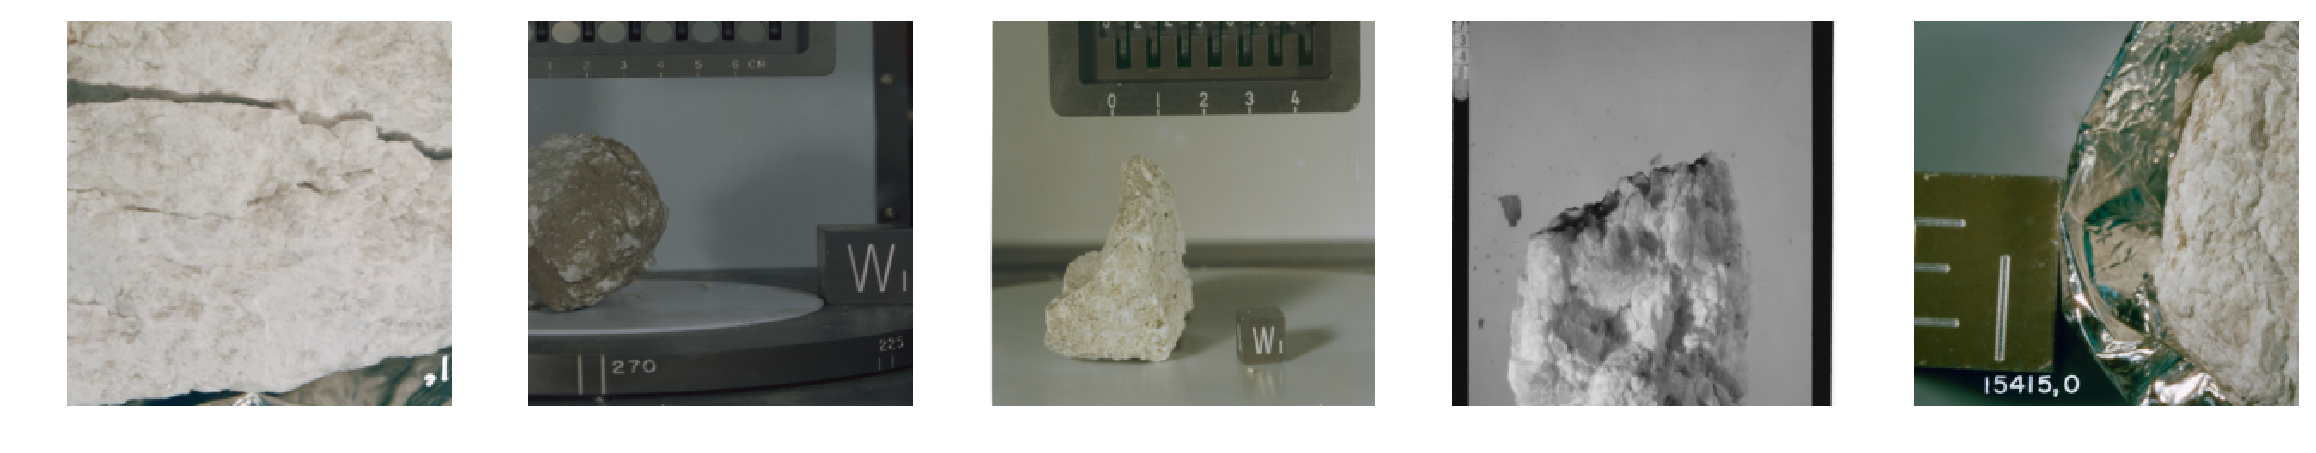

In [28]:
images, labels = get_random_images(5)

to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20,20))
classes = trainloader.dataset.classes

for image_index in range(len(images)):
    image = to_pil(images[image_index])
    sub = fig.add_subplot(1, 5, image_index+1)
    plt.axis('off')
    plt.imshow(image)

plt.show()

In [24]:
# Determine if you're using a CPU or a GPU device to build the deep learning network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

In [25]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048,512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.003)

model.to(device)
print('done')

done


In [26]:
# Set the initial number of iterations to search for associations
epochs = 5
print_every = 5

# Initialize the loss variables
running_loss = 0
train_losses, test_losses = [], []

# Track the current training step, start at 0
steps = 0

# Search for associations in the features
for epoch in range(epochs):

   # Count each epoch
   epoch += 1

   # Load in all of the image inputs and labels from the TRAIN loader 
   for inputs, labels in trainloader:

      # Count each training step
      steps += 1
      print('Training step ', steps)

      # Load the inputs and labels to the already selected device
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero out gradients to avoid accumulations of gradiants across training iterations
      optimizer.zero_grad()

      # Pass the images through the model, return the log probabilities of each label
      logps = model.forward(inputs)

      # Run the log probabilities through the criterion to get the output graph
      loss = criterion(logps, labels)

      # Use the loss graph to compute gradients
      loss.backward()

      # Update the parameters based on the current gradient
      optimizer.step()

      # Add the actual loss number to the running loss total
      running_loss += loss.item()

      # Every 5 steps, evaluate the model
      if steps % print_every == 0:

         # Initialize loss and accuracy
         test_loss = 0
         accuracy = 0

         # Start the model evaluation
         model.eval()

         # Refine the accuracy of the prediction without updating the gradients
         with torch.no_grad():

            # Load in all of the image inputs and labels from the TEST loader 
            for inputs, labels in testloader:

               # Load the inputs and labels to the already selected device
               inputs, labels = inputs.to(device), labels.to(device)

               # Pass the images through the model, return the log probabilities of each label
               logps = model.forward(inputs)

               # Run the log probabilities through the criterion to get the output graph
               batch_loss = criterion(logps, labels)

               # Add the actual loss number to the running loss total for the test batch
               test_loss += batch_loss.item()

               # Return a new tensor with the true probabilities
               ps = torch.exp(logps)

               # Return the largest probability and class of the new tensor along a given dimension
               top_p, top_class = ps.topk(1, dim=1)

               # Reshape the tensor to match the same shape as the top class
               equals = top_class == labels.view(*top_class.shape)

               # Compute the accuracy and add it to the running accuracy count for the test batch
               accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

         # Append the training and testing losses
         train_losses.append(running_loss/len(trainloader))
         test_losses.append(test_loss/len(testloader))  

         # Display the accuracy of the prediction with 3 digits in the fractional part of the decimal
         print(f"\n     Epoch {epoch}/{epochs}: "
               f"Train loss: {running_loss/print_every:.3f}.. "
               f"Test loss: {test_loss/len(testloader):.3f}.. "
               f"Test accuracy: {accuracy/len(testloader):.3f}\n")

         # Train the model
         running_loss = 0
         model.train()

         # After 5 training steps, start the next epoch
         # Break here in case the trainloader has remaining data
         break

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5

     Epoch 1/5: Train loss: 1.634.. Test loss: 0.540.. Test accuracy: 0.744

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10

     Epoch 2/5: Train loss: 0.405.. Test loss: 0.704.. Test accuracy: 0.644

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15

     Epoch 3/5: Train loss: 0.586.. Test loss: 1.724.. Test accuracy: 0.579

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20

     Epoch 4/5: Train loss: 0.647.. Test loss: 0.518.. Test accuracy: 0.675

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25

     Epoch 5/5: Train loss: 0.546.. Test loss: 0.363.. Test accuracy: 0.838



0.8671875